# Compare Classifiers
Included so far:
- SVM
- LSTM
- Gradient Boost
- AdaBoost
- Random Forest
- KNN

In [6]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

    
from pathlib import Path
try:
    try:
        json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
    except FileNotFoundError:
        json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

    with open(str(json_path)) as f:
        j = json.load(f)

    personal_dbox_path = Path(j['personal']['path'])
    # Save the images directly into the dropbox where the overleaf document is stored
    IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')

except Exception as e:
    IMAGES_PATH = "../images"
    print(e)
    
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if fig_id is None:
        print("Error while saving an image! Figure ID is None!")
        return
    
    
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

from machine_learning_load_data import loadOnlineEEGdata
from utils import loadTargetLabelsTxt

/home/nvidia/masterthesis/thesis_eeg/code
argument should be a path or str object, not <class 'NoneType'>
Saving images to: ../images


In [1]:
# Load some online EEG Data
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../../EEG_Data/eeg_data_online', splitData=True)
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../../EEG_Data/muse_data', splitData=True)

##################
# online eeg data
##################
X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = eegData
X_train_freq, y_train_freq, X_test_freq, y_test_freq = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
X_train_freq = X_train_freq.reshape(X_train_freq.shape[0], X_train_freq.shape[2])
X_test_freq = X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])

targetLabelsDict = loadTargetLabelsTxt(filePath='../../EEG_Data/eeg_data_online/target_labels.txt')
targetNames = ['Fatigue ({})'.format(targetLabelsDict['FATIGUE']),
               'Normal ({})'.format(targetLabelsDict['NORMAL'])]


##################
# experiment data
##################
X_train_eeg_exp, y_train_eeg_exp, X_test_eeg_exp, y_test_eeg_exp = eegData_exp
X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp = freqData_exp
X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp = entropyData_exp


# reshape
X_train_freq_exp = X_train_freq_exp.reshape(X_train_freq_exp.shape[0], X_train_freq_exp.shape[2])
X_test_freq_exp = X_test_freq_exp.reshape(X_test_freq_exp.shape[0], X_test_freq_exp.shape[2])

X_train_entropy_exp = X_train_entropy_exp.reshape(X_train_entropy_exp.shape[0], X_train_entropy_exp.shape[2])
X_test_entropy_exp = X_test_entropy_exp.reshape(X_test_entropy_exp.shape[0], X_test_entropy_exp.shape[2])

targetLabelsDict_exp = loadTargetLabelsTxt(filePath='../../EEG_Data/muse_data/target_labels.txt')
targetNames_exp = ['AWAKE ({})'.format(targetLabelsDict_exp['AWAKE']),
               'FATIGUE ({})'.format(targetLabelsDict_exp['FATIGUE'])]

ImportError: No module named 'utils'

### Create Models

In [3]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

randomState = 42
modelList = []

# LSTM - takes a lot of time...



def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#modelList.append(("LSTM", "predict_proba", KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)))

# Gradient Boost
modelList.append(("Gradient Boost", "decision_function", GradientBoostingClassifier(n_estimators=1000,
                                                                                   loss='deviance',
                                                                                   learning_rate=0.1)))

# AdaBoost
modelList.append(("Ada Boost", "decision_function", AdaBoostClassifier(n_estimators=500 , learning_rate=1)))

# SVM
modelList.append(("SVM", "decision_function", svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=randomState, shrinking=True,
  tol=0.001, verbose=False)))

# Random Forest
modelList.append(("Random Forest", "predict_proba", RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                                                           criterion='entropy', max_depth=None, max_features='log2',
                                                                           max_leaf_nodes=None, max_samples=None,
                                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                                           min_samples_leaf=1, min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                                                                           n_jobs=None, oob_score=False, random_state=None,
                                                                           verbose=0, warm_start=False)))

# KNN
modelList.append(("KNN", "predict_proba", KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                                               metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                                                               weights='distance')))

# Multi Layer Perceptron
modelList.append(("Multilayer perceptron", "predict_proba", MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
                                                                          beta_2=0.999, early_stopping=False, epsilon=1e-08,
                                                                          hidden_layer_sizes=(2, 100), learning_rate='constant',
                                                                          learning_rate_init=0.001, max_fun=15000, max_iter=200,
                                                                          momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                                                                          power_t=0.5, random_state=None, shuffle=True, solver='adam',
                                                                          tol=0.0001, validation_fraction=0.1, verbose=False,
                                                                          warm_start=False)))


# Decision Tree
modelList.append(('Decision Tree', 'predict_proba', DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                                                                           max_depth=None, max_features=None, max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                                                           min_samples_leaf=1, min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0, presort='deprecated',
                                                                           random_state=None, splitter='random')))


Using TensorFlow backend.
/home/nvidia/venv/ml/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nvidia/venv/ml/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nvidia/venv/ml/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nvidia/venv/ml/lib/python3.5/site-packages/tensorflow/py

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import time

def plot_roc_curve(fpr, tpr, label=None, title="ROC Curve"):
    plt.title(title)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)  

def evaluteModelsWithRocCurve(modelList, X, y, title, target_names, kFoldTimes=5):
    print("X shape: {}".format(X.shape))
    print("y shape: {}".format(y.shape))
    
    title = title + " - k-fold times: {}".format(kFoldTimes)
    
    n_timesteps, n_features, n_outputs = 1, X.shape[1], 2
    plt.figure(figsize=(8, 6))

    for modelName, method, model in modelList:
        start_time = time.time()
        print("Evalute Model: '{}'...".format(modelName))
        try:
            if modelName == "LSTM":
                n_timesteps, n_features, n_outputs = 1, X.shape[1], 2
                y_predict = cross_val_predict(model, X.reshape(X.shape[0], 1, X.shape[1]), y, cv=kFoldTimes, method=method, n_jobs=-1)
            else:
                y_predict = cross_val_predict(model, X, y, cv=kFoldTimes, method=method, n_jobs=-1)



            if method == 'predict_proba':
                y_scores = y_predict[:, 1] # score = proba of positive class
                fpr, tpr, thresholds = roc_curve(y, y_scores)

            elif method == 'decision_function':
                fpr, tpr, thresholds = roc_curve(y, y_predict)

            else:
                print("Method '{}' not supported yet!".format(method))

            plot_roc_curve(fpr, tpr, modelName, title=title)
        except Exception as e:
            print ("Error with model: {}".format(modelName))
            raise(e)
        finally:
            print('Minutes taken: {} for Model {}'.format((time.time() - start_time)/60, modelName))
        
    try:
        print(classification_report(y, y_predict, target_names=target_names))
    except Exception as e:
        print(e)
    
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=16)
    save_fig(title)
    plt.show()

## Plot with Online EEG Data

X shape: (5024, 200)
y shape: (5024,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 6.107745269934337 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 1.6820136030515036 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.04130064646402995 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 1.3212508678436279 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.09898888270060222 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.26769840717315674 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.004508554935455322 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 4


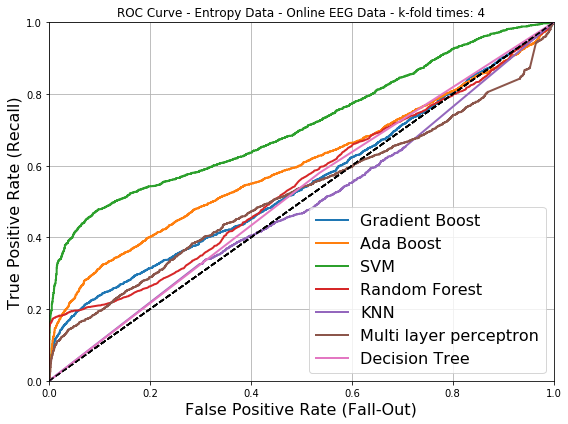

X shape: (5024, 200)
y shape: (5024,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 13.660568265120189 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 3.567019744714101 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.08097127278645834 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 2.8334689100583392 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.11605167388916016 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.502412748336792 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.008755274613698323 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 6


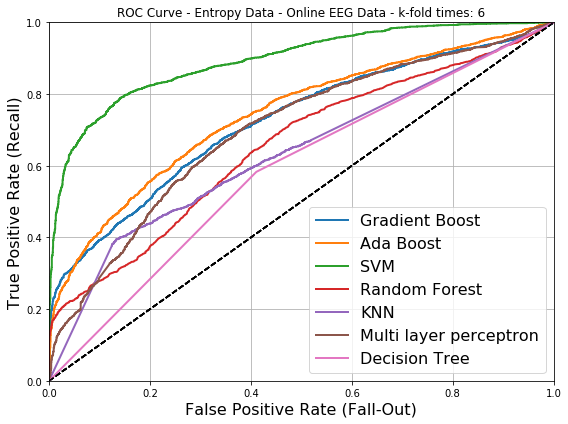

X shape: (5024, 200)
y shape: (5024,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 15.433805565039316 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 3.9369251410166424 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.10325633684794108 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 3.1137218435605365 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.12369947036107382 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.5844293276468913 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.011397099494934082 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 8


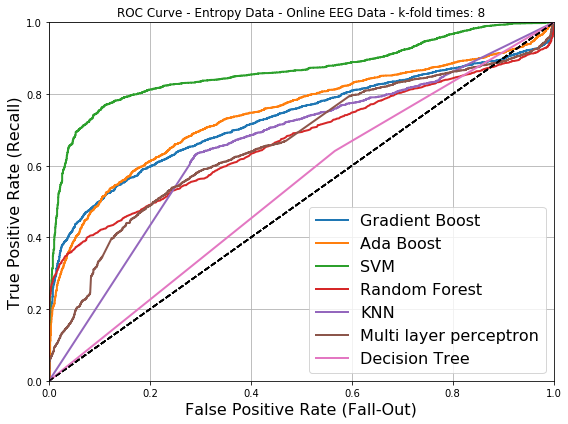

X shape: (5024, 200)
y shape: (5024,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 23.529212196667988 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 5.886734342575073 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.14512619972229004 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 4.769846586386363 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.12634859482447305 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.6727347373962402 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.015154850482940675 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 10


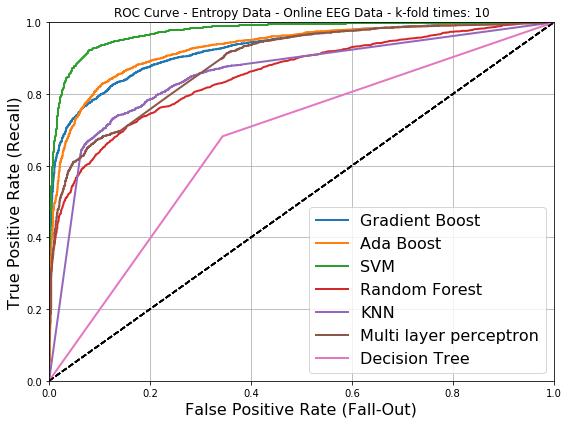

In [17]:
kFoldTimesList = [4, 6, 8, 10]

for k in kFoldTimesList:
    evaluteModelsWithRocCurve(modelList, X=X_train_entropy, y=y_train_entropy,
                          title="ROC Curve - Entropy Data - Online EEG Data", target_names=targetNames,
                          kFoldTimes=k)

X shape: (1008, 1200)
y shape: (1008,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 2.673876718680064 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 1.7481194257736206 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.043124504884084064 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.37055381933848064 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.027543310324350992 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.09572399059931437 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0054609417915344235 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 4


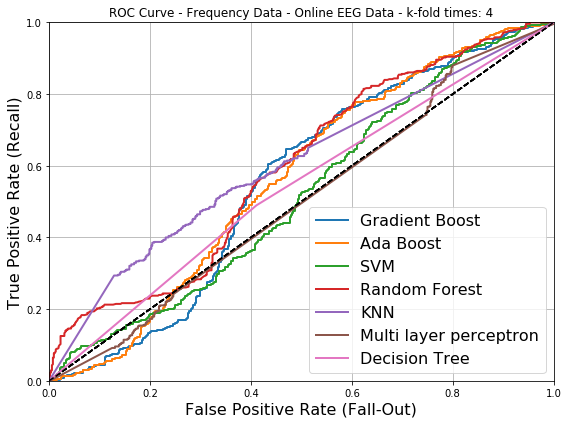

X shape: (1008, 1200)
y shape: (1008,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 5.853130865097046 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 3.710938580830892 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.07521532773971558 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.7788266102472942 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.033336639404296875 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.2368115743001302 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.009458800156911215 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 6


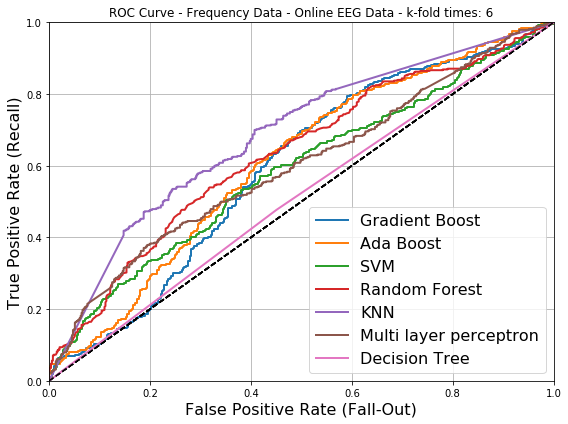

X shape: (1008, 1200)
y shape: (1008,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 7.175323351224264 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 4.045729076862335 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.09861472050348917 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.859403137365977 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.03483967383702596 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.26106196641921997 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.011439581712086996 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 8


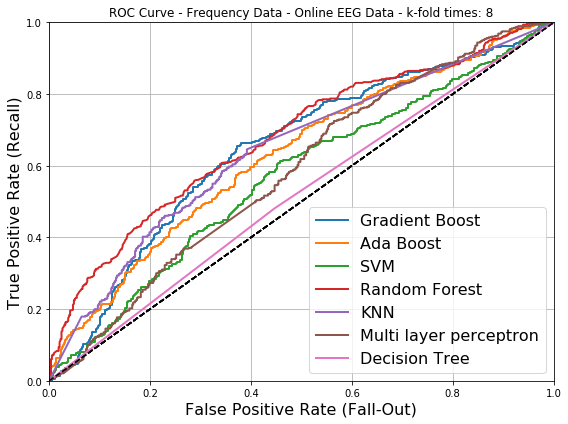

X shape: (1008, 1200)
y shape: (1008,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 10.78135214249293 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 6.086544871330261 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.13355505069096882 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 1.2977666020393372 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.03762653668721517 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.38092830578486125 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.01615853706995646 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 10


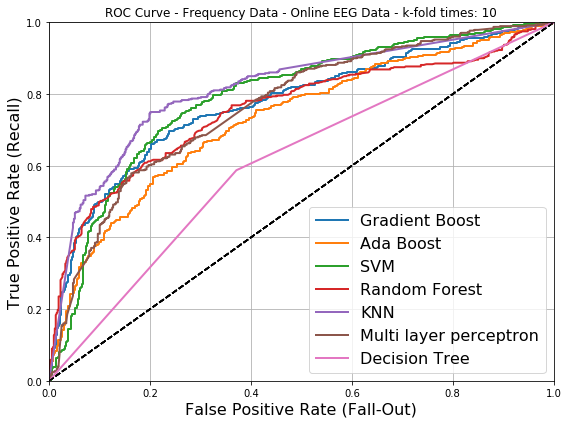

In [18]:
kFoldTimesList = [4, 6, 8, 10]

for k in kFoldTimesList:
    evaluteModelsWithRocCurve(modelList, X=X_train_freq, y=y_train_freq,
                          title="ROC Curve - Frequency Data - Online EEG Data",
                          target_names=targetNames, kFoldTimes=k)

# Plot with Experiment Data

X shape: (3306, 20)
y shape: (3306,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 0.4940264344215393 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.17716185649236044 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 99.9976204276085 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.6462922732035319 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.0036231120427449542 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.1407934625943502 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0013523419698079427 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 4


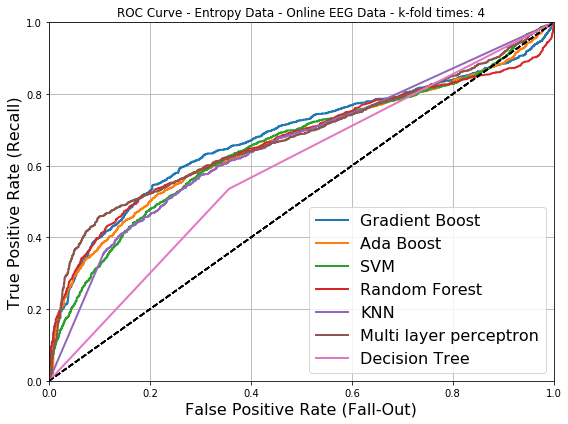

X shape: (3306, 20)
y shape: (3306,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 1.0374300678571065 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.3622499664624532 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 71.15320380528767 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 1.3465603788693745 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.006265592575073242 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.27495954831441244 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.002213859558105469 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 6


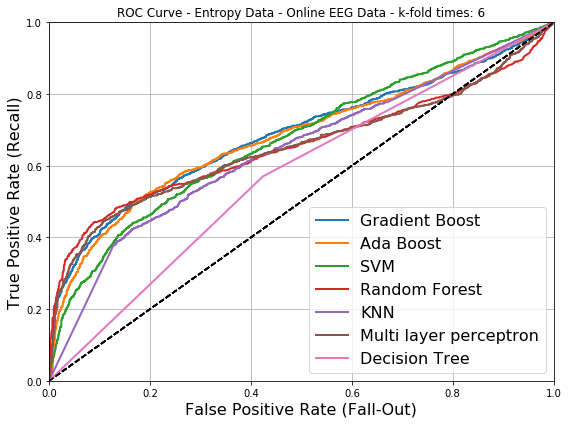

X shape: (3306, 20)
y shape: (3306,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 1.1368388454119365 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.39783302545547483 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 230.85346502065659 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 1.503527283668518 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.006391358375549316 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.31132243474324545 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0022842844327290853 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 8


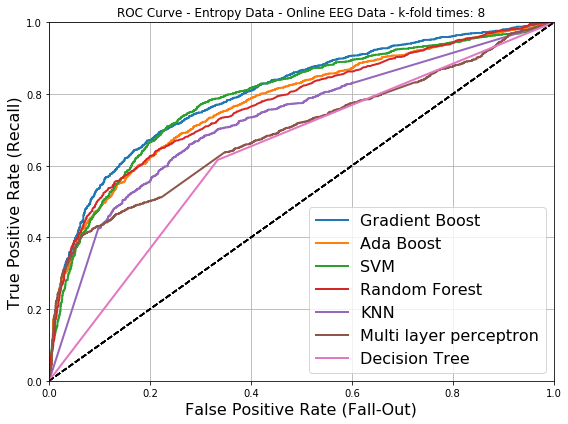

X shape: (3306, 20)
y shape: (3306,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 1.6930972337722778 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.5840362946192423 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 204.5228765686353 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 2.1928086717923483 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.008096714814503988 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.45675063530604043 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.002743669350941976 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Entropy Data - Online EEG Data - k-fold times: 10


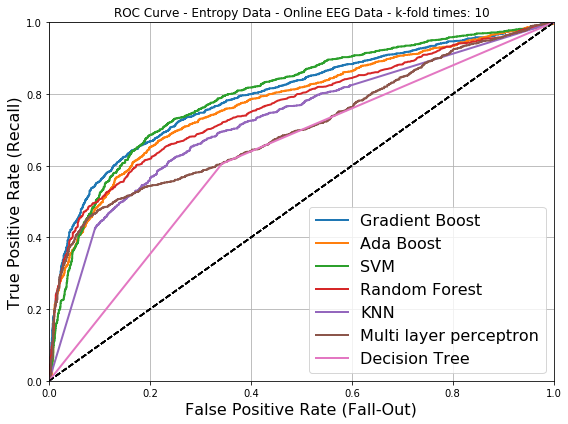

In [19]:
kFoldTimesList = [4, 6, 8, 10]

for k in kFoldTimesList:
    evaluteModelsWithRocCurve(modelList, X=X_train_entropy_exp, y=y_train_entropy_exp,
                              title="ROC Curve - Entropy Data - Online EEG Data", target_names=targetNames_exp,
                              kFoldTimes=k)

X shape: (665, 120)
y shape: (665,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 0.058632043997446696 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.16815900405248005 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.002043779691060384 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.1486492395401001 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.003276213010152181 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.0370831290880839 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0013361851374308269 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 4


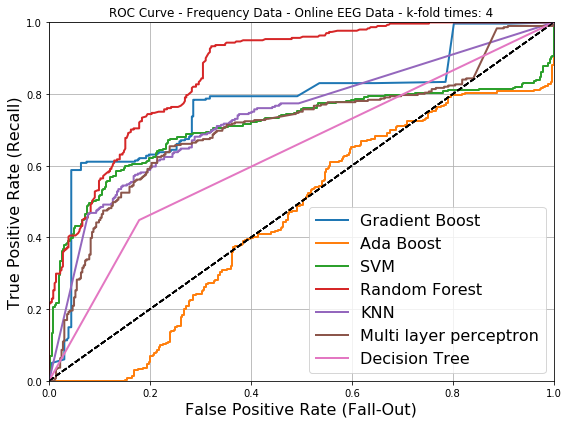

X shape: (665, 120)
y shape: (665,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 0.10459070205688477 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.35013935168584187 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.004017651081085205 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.29872832298278806 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.005623805522918701 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.07192234595616659 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0018790006637573243 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 6


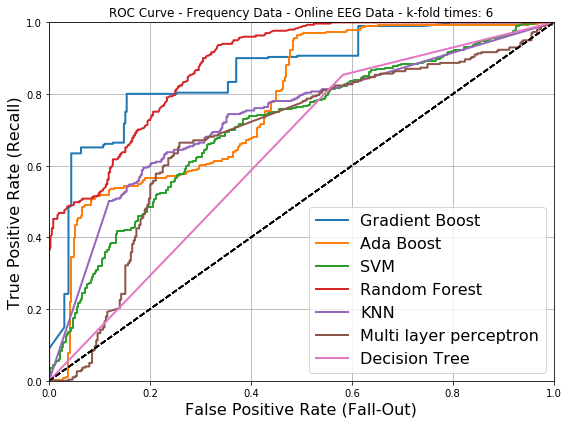

X shape: (665, 120)
y shape: (665,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 0.1292789340019226 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.3760269681612651 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.0043348232905069985 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.32693626085917155 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.005305675665537516 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.0803412675857544 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0020225882530212403 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 8


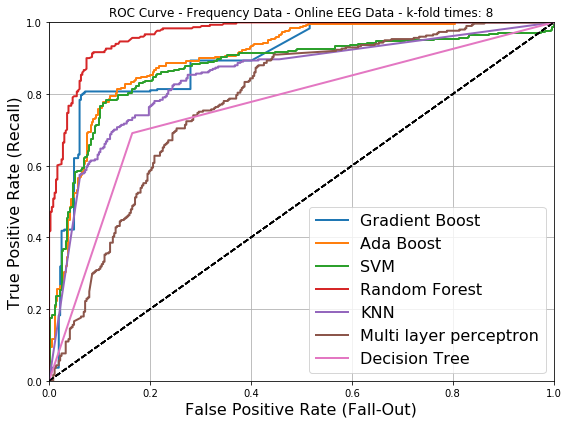

X shape: (665, 120)
y shape: (665,)
Evalute Model: 'Gradient Boost'...
Minutes taken: 0.18392305771509807 for Model Gradient Boost
Evalute Model: 'Ada Boost'...
Minutes taken: 0.5576739509900411 for Model Ada Boost
Evalute Model: 'SVM'...
Minutes taken: 0.005929259459177653 for Model SVM
Evalute Model: 'Random Forest'...
Minutes taken: 0.47975784142812095 for Model Random Forest
Evalute Model: 'KNN'...
Minutes taken: 0.008105230331420899 for Model KNN
Evalute Model: 'Multi layer perceptron'...
Minutes taken: 0.08269368012746176 for Model Multi layer perceptron
Evalute Model: 'Decision Tree'...
Minutes taken: 0.0024355014165242514 for Model Decision Tree
Classification metrics can't handle a mix of binary and multilabel-indicator targets
Saving figure ROC Curve - Frequency Data - Online EEG Data - k-fold times: 10


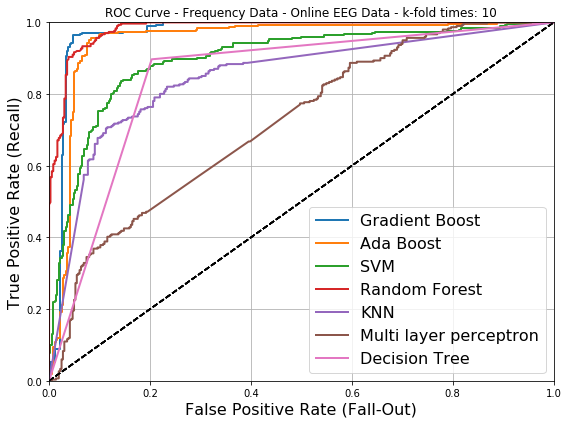

In [20]:
kFoldTimesList = [4, 6, 8, 10]

for k in kFoldTimesList:
    evaluteModelsWithRocCurve(modelList, X=X_train_freq_exp, y=y_train_freq_exp,
                              title="ROC Curve - Frequency Data - Online EEG Data",
                              target_names=targetNames_exp, kFoldTimes=k)